# Comparing DCT Types

The different versions of DCT really come from [different periodic extensions](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Informal_overview). From [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf) we know it's convenient to use the DCT-I, but it's worth asking which variant is actually the "best" in some kind of measurable error sense.

In [1]:
import pandas, numpy as np
from scipy.fft import dct, dst
from matplotlib import pyplot
from IPython.display import HTML, display

## A Scheme

Let's:
1. take a function, and sample it at `N + 1` points to create a vector,
2. DCT that vector using various definitions, then
3. inverse DCT using the appropriate inverses with `N + 1` continuous cosine modes so we can
4. see how close we get throughout the whole domain.

We'll need to work with an *even* function, but we create this by picking any function to the right side of zero and reflecting it back across the axis. So let's work with the one-sided domain, $[0, \pi]$. We choose $\pi$ as the endpoint and make it inclusive, because $\cos(\pi) =-1$ is inclusive in the Chebyshev domain, $[-1, 1]$, and because the DCT has a domain half the length of the DFT, which is $2\pi$. See the [figures here](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Informal_overview).

### Test Functions

A couple classic aperiodic functions, their aperiodic cosine-warps, and one easy case that's periodic and *even* on $[0, 2\pi)$, so we can guaranteed construct it out of cosines.

In [2]:
y = lambda th: np.exp(th) * np.sin(5*th)
dy = lambda th: np.exp(th) * (5*np.cos(5*th) + np.sin(5*th))
d2y = lambda th: 2*np.exp(th) * (5*np.cos(5*th) - 12*np.sin(5*th))

y_cos = lambda th: np.exp(np.cos(th)) * np.sin(5*np.cos(th))
dy_cos = lambda th: -np.exp(np.cos(th)) * np.sin(th) * (5*np.cos(5*np.cos(th)) + np.sin(5*np.cos(th)))
d2y_cos = lambda th: -np.exp(np.cos(th)) * (np.cos(th)*(5*np.cos(5*np.cos(th)) + np.sin(5*np.cos(th))) + 2*np.sin(th)**2 * (-5*np.cos(5*np.cos(th)) + 12*np.sin(5*np.cos(th))))

u = lambda th: np.sin(8*(th+1))/((th + 1.1)**(3/2))
du = lambda th: ((8.8 + 8*th)*np.cos(8*(1 + th)) - 1.5*np.sin(8*(1 + th)))/(1.1 + th)**(5/2)
d2u = lambda th: -(24*np.cos(8*(1 + th)))/(1.1 + th)**(5/2) + (15*np.sin(8*(1 + th)))/(4*(1.1 + th)**(7/2)) - (64*np.sin(8*(1 + th)))/(1.1 + th)**(3/2)

u_cos = lambda th: np.sin(8*(np.cos(th)+1))/((np.cos(th) + 1.1)**(3/2))
du_cos = lambda th: -(8*np.sin(th)*((1.1 + np.cos(th))*np.cos(8*(1 + np.cos(th))) - 0.1875*np.sin(8*(1 +np.cos(th)))))/(1.1 +np.cos(th))**(5/2)
d2u_cos = lambda th: -24*np.sin(th)**2 * np.cos(8*(np.cos(th)+1))/(np.cos(th)+1.1)**(5/2) + (3/2*np.cos(th)/(np.cos(th) + 1.1)**(5/2) + 15/4*(np.sin(th)**2)/(np.cos(th) + 1.1)**(7/2))*np.sin(8*(np.cos(th)+1)) + (-8*np.cos(th)*np.cos(8*(np.cos(th)+1)) - 64*np.sin(th)**2 * np.sin(8*(np.cos(th)+1)))/(np.cos(th)+1.1)**(3/2)

z = lambda th: np.cos(3*th) + 3*np.cos(5*th) # even function, only cosines so the DCT can truly capture it
dz = lambda th: -3*np.sin(3*th) - 15*np.sin(5*th) # odd function, analytic, known derivative
d2z = lambda th: -9*np.cos(3*th) - 75*np.cos(5*th)


In [3]:
th = np.linspace(0, np.pi, 100) # dense samples of the domain

### Reconstruction and Plotting

In [4]:
def compare_dct(f, N, fname):
	"""plot reconstructions of a function based on N+1 DCT modes, and compare them to that function
	:param f: function to try to reconstruct
	:param N: f is sampled at N+1 points, making the last index N. Note this is different from the N used by
				https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html
	:param fname: which function is being plotted
	:param results: dataframe where results should be stashed
	"""
	th_n = np.linspace(0, np.pi, N+1, endpoint=True) # a subsampling of the domain
	y = f(th)
	y_n = f(th_n)
	
	pyplot.figure(figsize=(12,3))
	pyplot.plot(th, y, 'k', label=r'$f(\theta)$') # where the real function lives
	pyplot.plot(th_n, y_n, 'k+', label='type I samples') # where the real function samples live
	
	Y_1 = dct(y_n, 1)
	# reconstruct according to the DCT-I formula, which is its own inverse
	y_th_1 = Y_1[0] + Y_1[N]*np.cos(th*N) # (-1)^n = cos(pi*n), pi*n/N = th -> pi*n = th*N
	for k in range(1, N):
		y_th_1 += 2*Y_1[k]*np.cos(th*k) # continuous th takes the place of th_n = pi*n/N
	y_th_1 /= (2*N)
	pyplot.plot(th, y_th_1, 'b', label='DCT-I interpolation') # plot the full interpolation lives
	
	Y_2 = dct(y_n, 2)
	# reconstruct according to the DCT-III formula, which is the inverse of DCT-II
	y_th_23 = Y_2[0]
	for k in range(1, N+1):
		y_th_23 += 2*Y_2[k]*np.cos((k/(N+1))*(N*th + np.pi/2))
	y_th_23 /= 2*(N+1)
	pyplot.plot(th, y_th_23, 'r', label='DCT-II,III interpolation')
	
	Y_4 = dct(y_n, 4)
	# reconstruct according to the DCT-IV formula, which is its own inverse
	y_th_4 = 0
	for k in range(0, N+1):
		y_th_4 += 2*Y_4[k] * np.cos((2*th * N + np.pi)*(2*k + 1)/(4*N + 4))
	y_th_4 /= 2*(N+1)
	pyplot.plot(th, y_th_4, 'g--', label='DCT-IV interpolation')
	pyplot.title(rf"${fname}$")
	pyplot.xlabel(r"$\theta$")
	pyplot.legend()

	MSE.loc[fname, f"N={N}"] = '<br/>'.join([f"I:&ensp;&emsp;{np.sum((y - y_th_1)**2)/len(th):.5g}",
											f"II,III: {np.sum((y - y_th_23)**2)/len(th):.5g}",
											f"IV:&emsp;{np.sum((y - y_th_4)**2)/len(th):.5g}"])

## Comparison on Aperiodic Functions

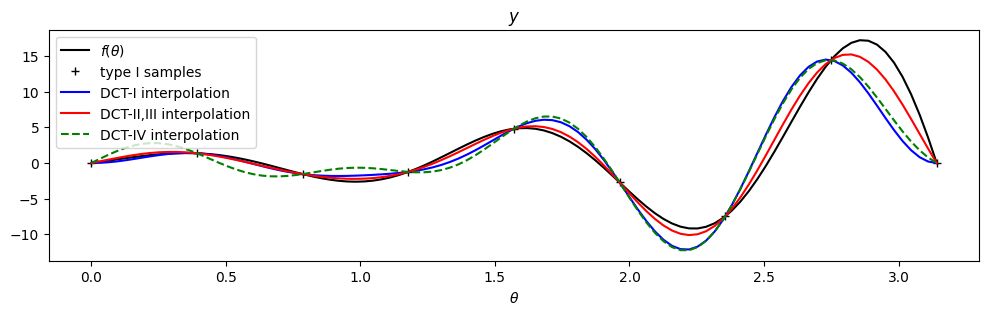

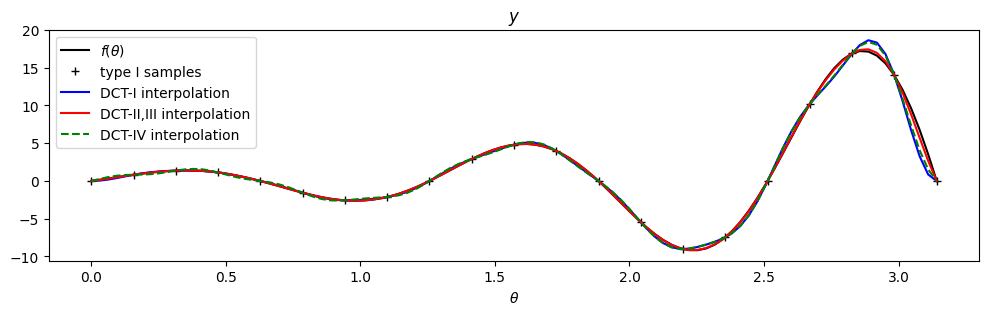

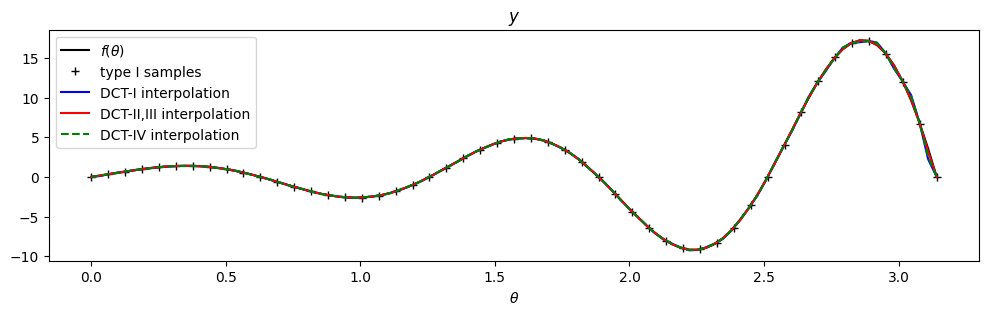

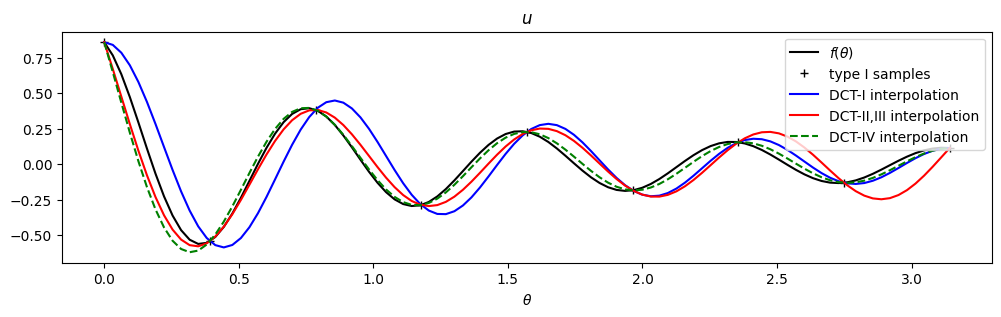

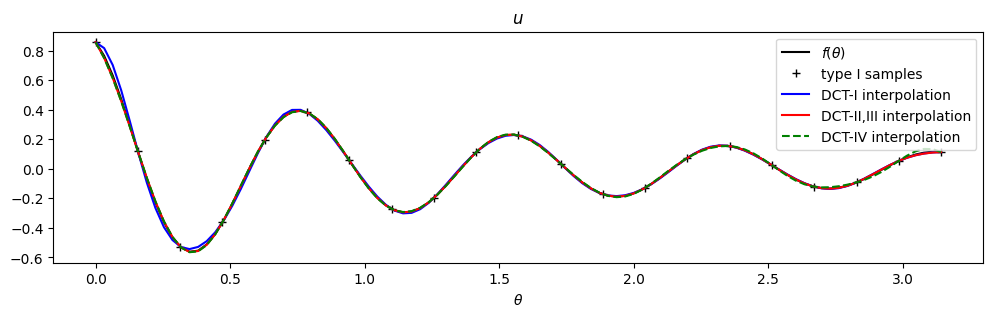

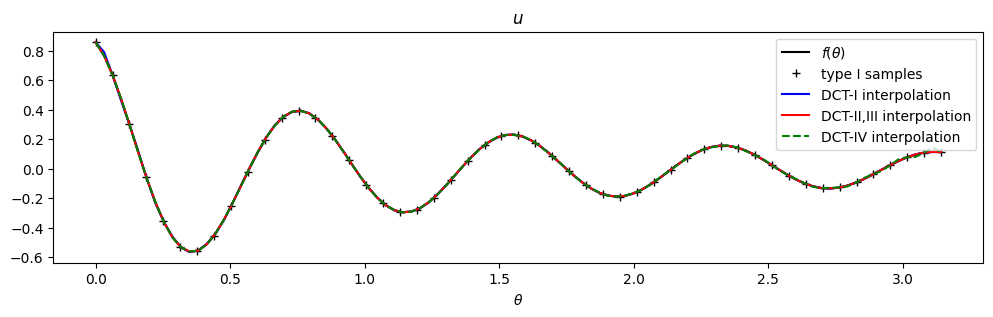

In [5]:
MSE = pandas.DataFrame()

compare_dct(y, 8, 'y')
compare_dct(y, 20, 'y')
compare_dct(y, 50, 'y')
compare_dct(u, 8, 'u')
compare_dct(u, 20, 'u')
compare_dct(u, 50, 'u')

In [6]:
display(HTML(MSE.style.set_caption("Mean Squared Error").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,N=8,N=20,N=50
y,"I: 8.1233II,III: 1.2912IV: 7.4641","I: 0.45131II,III: 0.030975IV: 0.31797","I: 0.027253II,III: 0.0014149IV: 0.018242"
u,"I: 0.029315II,III: 0.01388IV: 0.0051053","I: 0.00020405II,III: 8.3105e-06IV: 4.0116e-05","I: 1.0126e-05II,III: 4.9869e-08IV: 1.5382e-05"


So the DCT-I actually does the *worst* to reconstruct the function with very few modes, and the DCT-II,III pair does best, which may explain why the [DCT-II is the default](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html).

## Comparison on Warped Functions and Periodic Function

But when we take derivatives using cosine-spaced points, we're not really trying to express this $y(x)$; we're expressing $y(\cos(\theta))$, which is warped such that it no longer has sharp edges, becoming essentially $2\pi$-periodic when stacked against a mirror of itself.

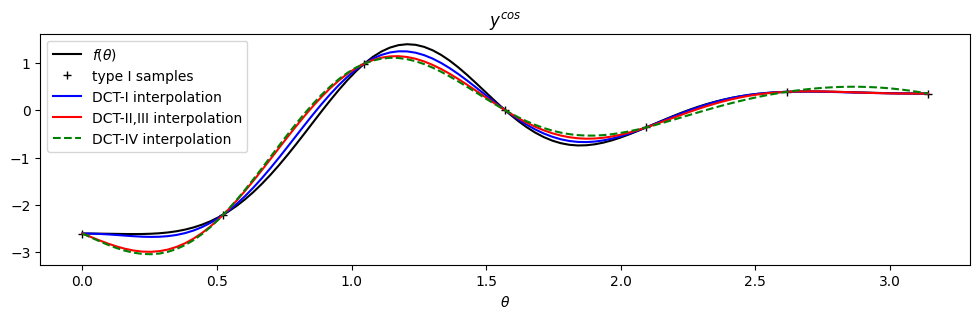

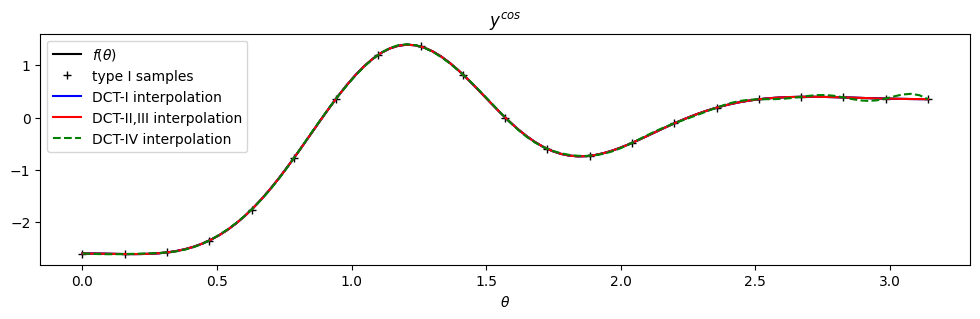

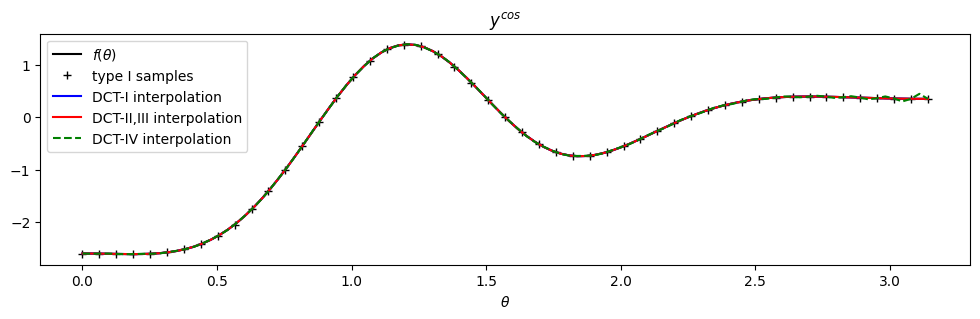

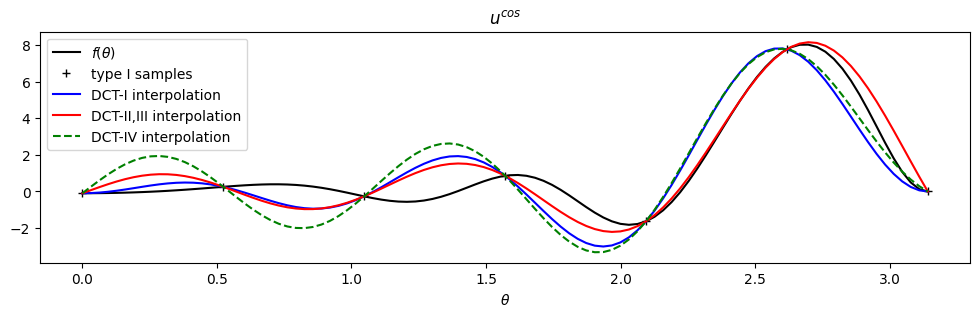

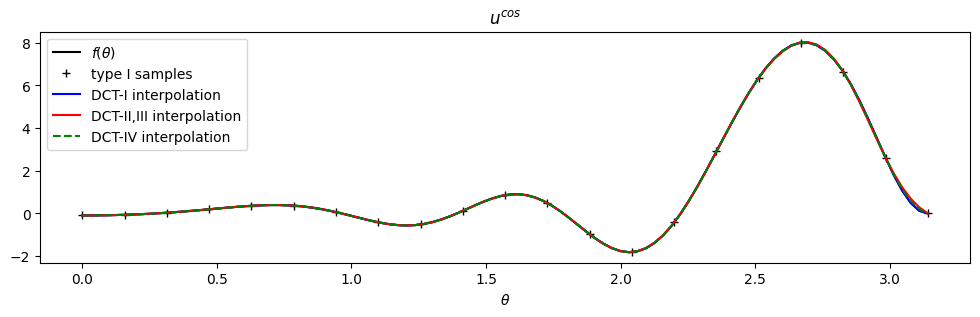

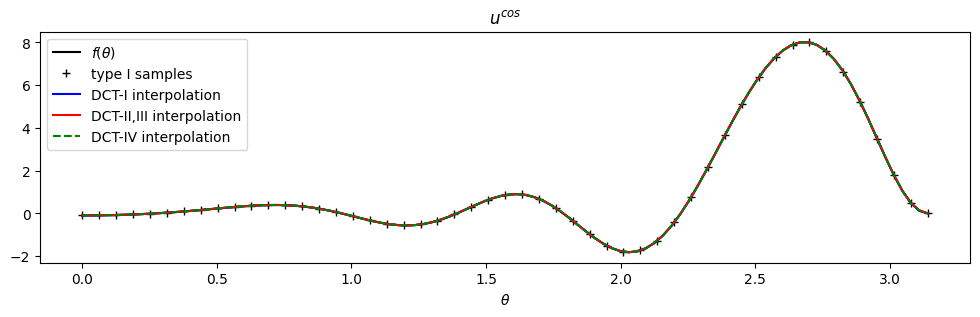

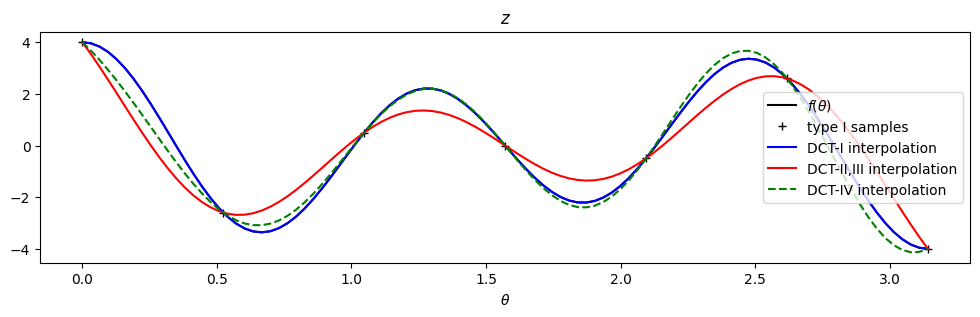

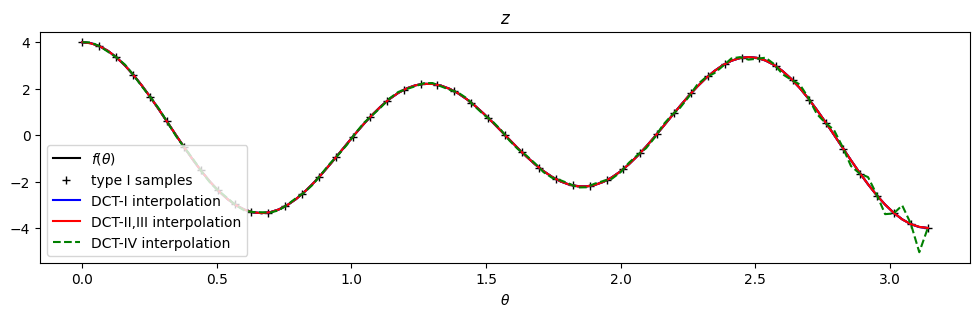

In [7]:
MSE = pandas.DataFrame()

compare_dct(y_cos, 6, 'y^{cos}')
compare_dct(y_cos, 20, 'y^{cos}')
compare_dct(y_cos, 50, 'y^{cos}')
compare_dct(u_cos, 6, 'u^{cos}')
compare_dct(u_cos, 20, 'u^{cos}')
compare_dct(u_cos, 50, 'u^{cos}')
compare_dct(z, 6, 'z')
compare_dct(z, 50, 'z')

In [8]:
display(HTML(MSE.style.set_caption("Mean Squared Error").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,N=6,N=20,N=50
y^{cos},"I: 0.0059748II,III: 0.034007IV: 0.04865","I: 4.2177e-23II,III: 4.0503e-08IV: 0.00043792","I: 4.2299e-31II,III: 2.3474e-10IV: 0.00016805"
u^{cos},"I: 1.3714II,III: 0.70332IV: 2.3701","I: 7.489e-06II,III: 0.001143IV: 0.00021203","I: 5.1426e-17II,III: 6.3108e-06IV: 1.4887e-06"
z,"I: 3.8826e-30II,III: 0.74132IV: 0.12365",nan,"I: 3.3999e-30II,III: 1.3272e-06IV: 0.021481"


In this case the *DCT-I* is the best option!

## Analysis and Discussion

Why is the DCT-II with type I points doing best for the aperiodic functions, and why is DCT-I doing much better for the periodic and cosine-warped ones?

First note that all DCT variants use the same $\theta \in [0, \pi]$, but the DCT-I assumes sampling at $\theta_n = \frac{\pi n}{N}$, which is $\{0, ... \pi\}$, while the DCT-II and IV actually expect sampling at $\theta_{n,II} = \frac{\pi}{N+1}(n+\frac{1}{2})$, which is $\{\frac{\pi}{2(N+1)}, ... \frac{\pi(N+\frac{1}{2})}{2(N+1)}\}$. In other words, the DCT-I expects to sample the function *all the way to the edges*, whereas the DCT-II and IV expect the function is continuing for another half-index-width ($\frac{\pi}{2N}$) off the ends of the sampling to cover the $\pi$-length interval in $(N+1)\Delta n$ instead of $N\Delta n$. But I've used the type-I sampling in all cases. How? This works because the relationship $\theta_{n,II} =\big( \frac{N}{N+1} \big) \theta_n + \frac{\pi}{2(N+1)}$ is affine, so feeding in $\theta_n$ effectively just makes the DCT-II and IV use lightly phase-shifted sinusoids with wavelengths scaled up by $\frac{N+1}{N}$, because the wavenumbers are now $k \frac{N}{N+1}$ instead of just integer $k$.

Think what this means: The DCT is reconstructing the function out of only cosines, so if our endpoints are *at* 0 and $\pi$ and we only have integer wavenumbers, then the reconstruction *must* flatten out there, because $\frac{d}{d\theta} \cos(k\theta) |_0 = \frac{d}{d\theta} \cos(k\theta) |_\pi = 0$. We observe this in the plots above when using DCT-I reconstructions. But if our sinusoids are slightly *longer* wavelength and then phase shifted to be symmetrical on the $[0, \pi]$ interval, then we can have nonzero slope at 0 and $\pi$! That is, if we're trying to fit a function with *sharp edges*, then the DCT-II affords us *wiggle room* between end samples [and their repeats](https://en.wikipedia.org/wiki/Discrete_cosine_transform#Informal_overview) in order to imagine a *smooth* (since we're only reconstructing from cosines) bend-around to meet the function's implicit mirror repeat. It's essentially hallucinating an extra little bit of function at the ends, which allows it to fit the function better between samples, especially at the edges of the domain.

This explains how the DCT-II has better ["energy compaction"](https://dsp.stackexchange.com/questions/96172/why-does-the-dct-ii-have-better-energy-compaction-than-dct-i) for most signals and why it's chosen as the default in `scipy`. In fact, the DCT-II basis functions closely resemble the [Karhunen–Loève Transform](https://www.farbrausch.de/%7Efg/articles/dct_klt.pdf) basis functions, which are provably the optimal basis to represent stationary (statistical properties not varying over time) Markov signals (where state at each point is dependent only on preceding neighboring state). Arbitrary smooth functions aren't exactly the same thing as this family, but they can be thought of as having some autocorrelation, so it's not a bad fit.

However, when sampling a function, even with sharp edges, at $x_n = \cos(\theta_n)$ linearly in $\theta \in [0, \pi]$, the effect is to *warp* the function in the $\theta$ domain in a way that flattens out the edges. It turns out this warped function doesn't need the extra wiggle room of the DCT-II and can be best reconstructed with the DCT-I!

# Derivatives with DCT

Let's cover some examples of taking the derivative in the Fourier domain, but with the DCT and DST rather than the FFT. There are a few possible methods.

In [9]:
N = 30
th_n = np.linspace(0, np.pi, N+1, endpoint=True)

## Derivatives with DCT-I/DST-I

This is covered more extensively in [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf).

$$
\begin{align*}
y_n &= \frac{1}{M} \Big( \underbrace{Y_0 + Y_N (-1)^n + 2 \sum_{k=1}^{N-1} Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big) \\
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \underbrace{2 \sum_{k=1}^{N-1} j (jk)^\nu Y_k \sin(\frac{\pi nk}{N})}_{\text{DST-I}} \\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{(j0)^\nu Y_0 + (jN)^\nu Y_N (-1)^n + 2 \sum_{k=1}^{N-1} (jk)^\nu Y_k \cos(\frac{\pi nk}{N})}_{\text{DCT-I}} \Big)
\end{align*}
$$

Notice we're sampling at:

$$\theta_n = \frac{\pi}{N}n$$

And the implicit vector underlying [a DFT equivalent to type-I](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationship.ipynb) has indices:

$$[0, 1, ... N-1, N, N-1, ... 1]$$

which has length $M = 2N$.

### DCT-I/DST-I on Examples

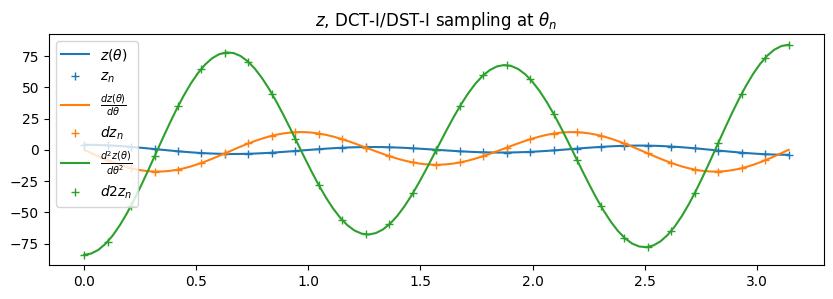

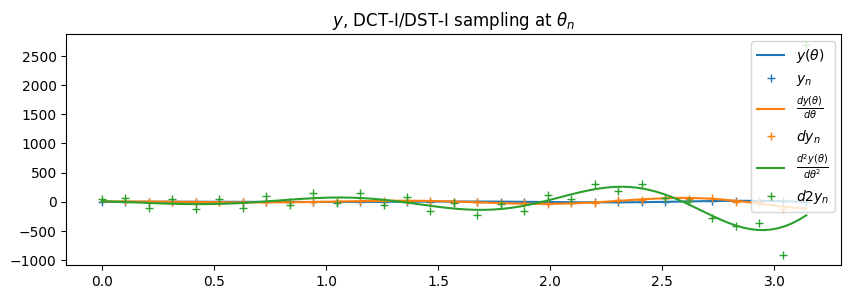

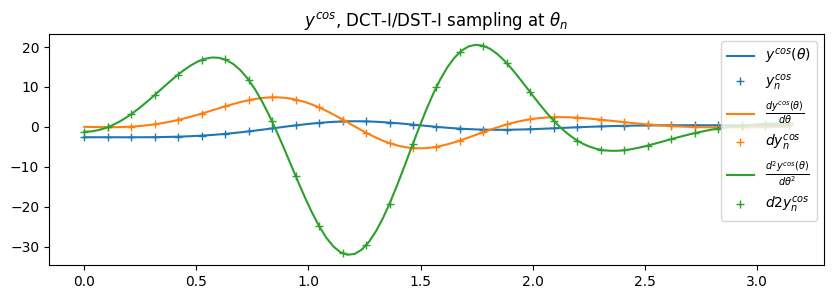

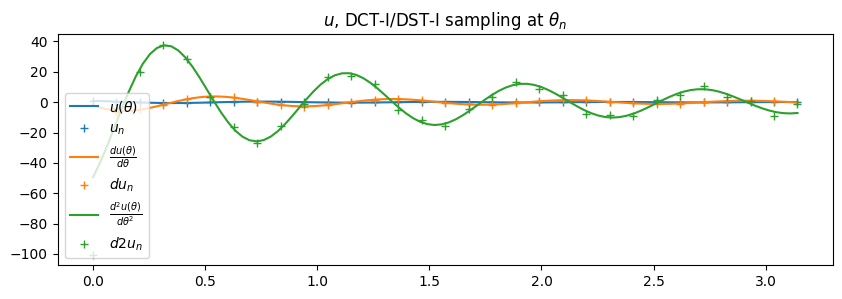

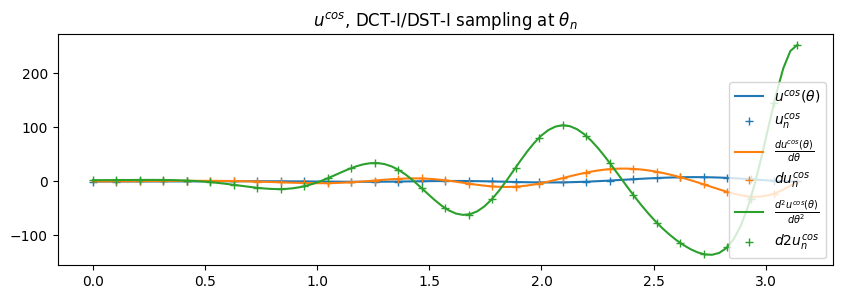

In [10]:
def dctIderivs(f, df, d2f, fname):
	M = 2*N
	k = np.arange(N+1); k[-1] = 0 # We zero out the Nyquist term, M/2 = N, corresponding to Y_N
	
	f_n = f(th_n)
	F_k = dct(f_n, 1)
	F_p = -k * F_k # j * (jk) * Y_k
	df_n = dst(F_p[1:-1], 1)/M # The DST-I definition takes only the central (nonzero) part of Y_p
	F_p = -k**2 * F_k # (jk)**2 * Y_k
	d2f_n = dct(F_p, 1)/M # IDCT-I

	Linf.loc[fname, f"I"] = '<br/>'.join([f"dy:&emsp;{np.max(np.abs(df_n - df(th_n)[1:-1])):.5g}",
											f"d2y: {np.max(np.abs(d2f_n - d2f(th_n))):.5g}"])

	pyplot.figure(figsize=(10,3))
	pyplot.plot(th, f(th), label=rf"${fname}(\theta)$")
	pyplot.plot(th_n, f_n, 'C0+', label=rf"${fname}_n$")
	pyplot.plot(th, df(th), label=rf"$\frac{{d{fname}(\theta)}}{{d\theta}}$")
	pyplot.plot(th_n[1:-1], df_n, 'C1+', label=rf"$d{fname}_n$")
	pyplot.plot(th, d2f(th), label=rf"$\frac{{d^2{fname}(\theta)}}{{d\theta^2}}$")
	pyplot.plot(th_n, d2f_n, 'C2+', label=rf"$d2{fname}_n$")
	pyplot.title(rf"${fname}$, DCT-I/DST-I sampling at $\theta_n$")
	pyplot.legend()

Linf = pandas.DataFrame()

dctIderivs(z, dz, d2z, 'z')
dctIderivs(y, dy, d2y, 'y')
dctIderivs(y_cos, dy_cos, d2y_cos, r'y^{cos}')
dctIderivs(u, du, d2u, 'u')
dctIderivs(u_cos, du_cos, d2u_cos, r'u^{cos}')


The numerically-found derivative matches the analytic truth really well for those functions which are periodic and not so well for those that aren't.

The endpoints are missing for the DST-I. This turns out to not be such a problem, though, because if taking Chebyshev derivatives via Fourier, we have to variable transform back to $x$ from $\theta$, which involves finding domain endpoints by [L'Hôpital's rule anyway](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb).

## Derivatives with DCT-II,III and DST-III using Type-II Sample Points

Type II transforms implicitly assume the data is coming from half-index points, $\theta_{n,II} = \frac{\pi}{N+1} (n + \frac{1}{2})$, and give back coefficients from whole number index points (wavenumbers in this case). The natural inverses are type III, which assume we're going from whole number index points back the original half-index sample points. Let's meet this assumption and carry through.

$$\begin{align*}
Y_{k,\text{II}} &= \underbrace{2 \sum_{n=0}^N y_{n,\text{II}} \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-II}}\\
y_{n,\text{II}} & = \frac{1}{M} \Big( \underbrace{Y_{0,\text{II}} + 2 \sum_{k=1}^N Y_{k,\text{II}} \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-III}} \Big)
\end{align*}$$

where this time $M = 2(N+1)$, because [the equivalent DFT](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dft_dct_dst_relationships.ipynb) assumes indices:

$$[0, 1, ... N-1, N, N, N-1, ... 1, 0]$$

If we substitute $\theta_{n,II}$ and then consider continuous $\theta$, then we get:

$$y(\theta) = \frac{1}{M} \Big( Y_{0,\text{II}} + 2 \sum_{k=1}^N Y_{k,\text{II}} \cos\!\big(k \theta \big) \Big)$$

We can then take the derivative w.r.t. $\theta$, similar to the [derivation of the type I case](https://pavelkomarov.com/spectral-derivatives/math.pdf), and then resample on the same grid to get:

$$\begin{align*}
y_{n,\text{II}}^{(\text{odd } \nu)} &= \frac{1}{M} \Big( \underbrace{\underbrace{(-1)^n}_{\sin\!\big(\frac{\pi (N + 1)}{N+1} (n + \frac{1}{2})\big)} \cdot \underset{\substack{\uparrow\\ Y^{(\nu)}_{N+1,\text{II}}}}{0} + 2 \sum_{k=1}^{N} Y_{k,\text{II}}^{(\nu)} \cdot j \sin\!\big(\frac{\pi k}{N+1}(n + \frac{1}{2})\big)}_{\text{DST-III}} \Big)\\
y_{n,\text{II}}^{(\text{even } \nu)} &= \frac{1}{M} \Big( \underbrace{\underset{\substack{\uparrow\\ Y_{0,\text{II}}^{(\nu)}}}{0} + 2 \sum_{k=1}^N Y_{k,\text{II}}^{(\nu)} \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-III}} \Big)
\end{align*}$$

where $Y_{k,\text{II}}^{(\nu)} = (jk)^\nu Y_{k,\text{II}}$.

For the DST case, [this stackoverflow post](https://stackoverflow.com/questions/57675927/how-to-calculate-spectral-derivative-using-scipy-fftpack-dst-dct) was really helpful, because `scipy` uses slightly different indexing and symbols than in my definitions here. Importantly, the DST-III takes $N$ elements, but due to a $+1$ offset of the summed-over indexer, the transform is effectively working over elements $k \in \{1, ... N+1\}$. This is because for this variant of the DST there is a zero crossing at $k = 0$, so that entry has no informational content. Because we need the $k = N+1$ element to be 0, and multiplying coefficients by $(jk)^\nu$ will give us elements $k \in \{0, ... N\}$ with the $k=0$ element 0, we can obtain what we need by `roll()`ing the coefficients to the left. The DCT-III is much more straightforward, taking elements $k = \{0, ... N\}$, just like the DCT-I.

### DCT-II/DST-III/DCT-III with Type-II Sampling on the Example

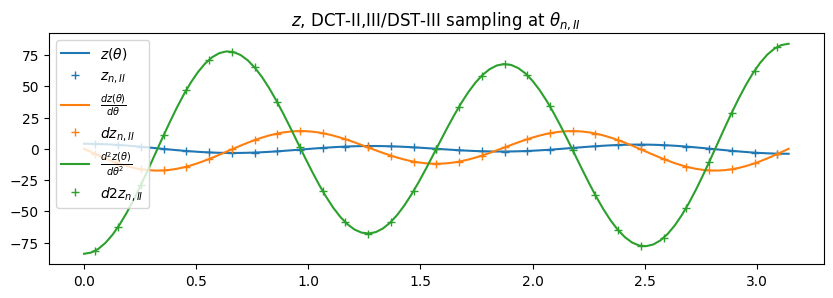

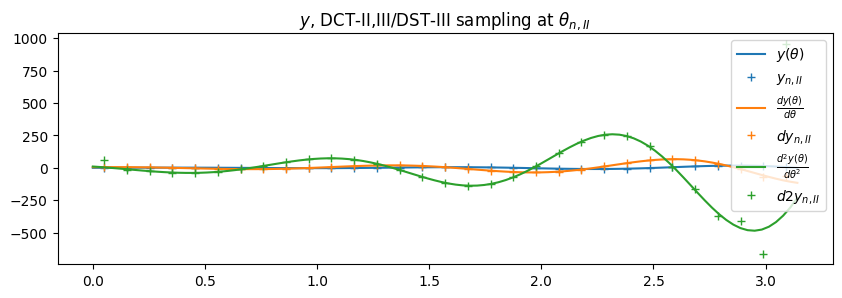

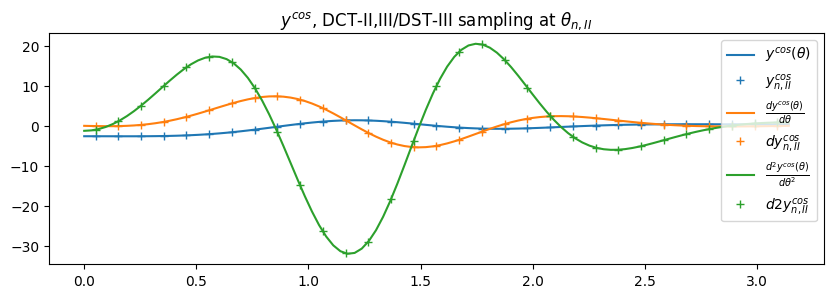

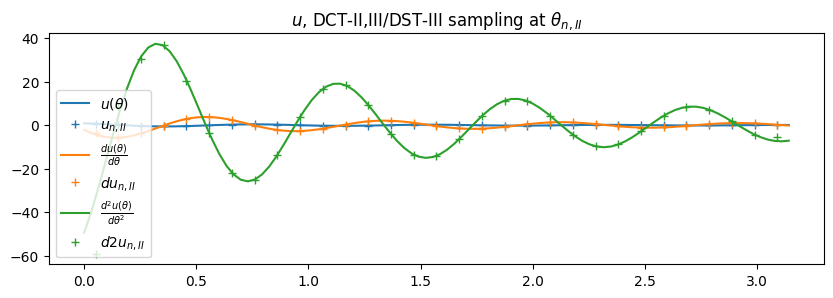

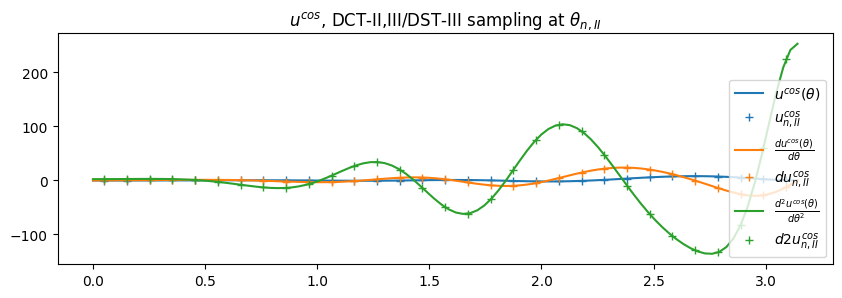

In [11]:
th_nII = np.pi/(N+1) * (np.arange(N+1) + 1/2)

def dctIIderivs(f, df, d2f, fname):
	M = 2*(N+1)
	k = np.arange(N+1) # This time *don't* zero out the last index, because the Nyquist term would be at N+1
	
	f_nII = f(th_nII) # Sample at half-index points
	F_kII = dct(f_nII, 2)
	F_pII = -k * F_kII # j * (jk) * Y_k
	F_pII = np.roll(F_pII, -1) # shift to left
	df_nII = dst(F_pII, 3)/M # DST-III
	F_pII = -k**2 * F_kII # (jk)**2 * Y_k
	d2f_nII = dct(F_pII, 3)/M # DCT-III

	Linf.loc[fname, f"II"] = '<br/>'.join([f"dy:&emsp;{np.max(np.abs(df_nII - df(th_nII))):.5g}",
											f"d2y: {np.max(np.abs(d2f_nII - d2f(th_nII))):.5g}"])

	pyplot.figure(figsize=(10,3))
	pyplot.plot(th, f(th), label=rf"${fname}(\theta)$")
	pyplot.plot(th_nII, f_nII, 'C0+', label=rf"${fname}_{{n,II}}$")
	pyplot.plot(th, df(th), label=rf"$\frac{{d{fname}(\theta)}}{{d\theta}}$")
	pyplot.plot(th_nII, df_nII, 'C1+', label=rf"$d{fname}_{{n,II}}$")
	pyplot.plot(th, d2f(th), label=rf"$\frac{{d^2{fname}(\theta)}}{{d\theta^2}}$")
	pyplot.plot(th_nII, d2f_nII, 'C2+', label=rf"$d2{fname}_{{n,II}}$")
	pyplot.title(rf"${fname}$, DCT-II,III/DST-III sampling at $\theta_{{n,II}}$")
	pyplot.legend()
	pyplot.show()

dctIIderivs(z, dz, d2z, 'z')
dctIIderivs(y, dy, d2y, 'y')
dctIIderivs(y_cos, dy_cos, d2y_cos, r'y^{cos}')
dctIIderivs(u, du, d2u, 'u')
dctIIderivs(u_cos, du_cos, d2u_cos, r'u^{cos}')

Once again, we match really well for the periodic functions and not so well for the ones with sharp corners, although these do a tiny bit better than in the DCT-I case.

Notice the type-II sampling doesn't get all the way to the edges of the domain, $[0, \pi]$. The natural exclusion of these points is inconvenient, because we'll need the boundaries if we want to impose boundary conditions. But when taking Chebyshev derivatives via Fourier, even in the DCT-I/DST-I case where the grid naturally includes the edges, the boundaries still [have to be treated specially](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb), so perhaps this is no worse.

## Derivatives with DCT-II,III and DST-III using Type-I Sample Points

It's possible to consider

$$
\begin{align*}
Y_{k,I,II} &= \underbrace{2 \sum_{n=0}^N y_n \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-II}}\\
y_n & = \frac{1}{M} \Big( \underbrace{Y_{0,I,II} + 2 \sum_{k=1}^N Y_{k,I,II} \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

where $y_n$ are taken from $\theta_n = \frac{\pi n}{N}$ sample points. If we take $\theta$ to be the continuous version of this sampling, then we can do a little algebra and find a continuous function:

$$y(\theta) = \frac{1}{M}\Big( Y_{0,I,II} + 2 \sum_{k=1}^N Y_{k,I,II} \cos\!\big(\frac{k}{N+1}(N\theta + \frac{\pi}{2}) \big) \Big)$$

where once again $M = 2(N+1)$, because the coefficients assume indices $[0, 1, ... N-1, N, N, N-1, ... 1, 0]$. This is what I do above in the [reconstruction and plotting](#Reconstruction-and-Plotting) function.

We can now take derivatives and re-discretize $\theta$ at the type-I points to find:

$$
\begin{align*}
y_n^{(\text{odd } \nu)} &= \frac{1}{M} \Big( \frac{N}{N+1} \Big)^\nu \Big( \underbrace{\underbrace{(-1)^n}_{\sin\!\big(\frac{\pi (N + 1)}{N+1} (n + \frac{1}{2})\big)} \cdot \underbrace{0}_{Y_{N+1,I,II}^{(\nu)}} + 2 \sum_{k=1}^{N} Y_{k,I,II}^{(\nu)} \cdot j \sin\!\big(\frac{\pi k}{N+1}(n + \frac{1}{2})\big)}_{\text{DST-III}} \Big)\\
y_n^{(\text{even } \nu)} &= \frac{1}{M} \Big( \frac{N}{N+1} \Big)^\nu \Big( \underbrace{\underbrace{0}_{Y_{0,I,II}^{(\nu)}} + 2 \sum_{k=1}^N Y_{k,I,II}^{(\nu)} \cos\!\big(\frac{\pi k}{N + 1}(n + \frac{1}{2})\big)}_{\text{DCT-III}} \Big)
\end{align*}
$$

### DCT-II/DST-III/DCT-III with Type-I Sampling on the Example

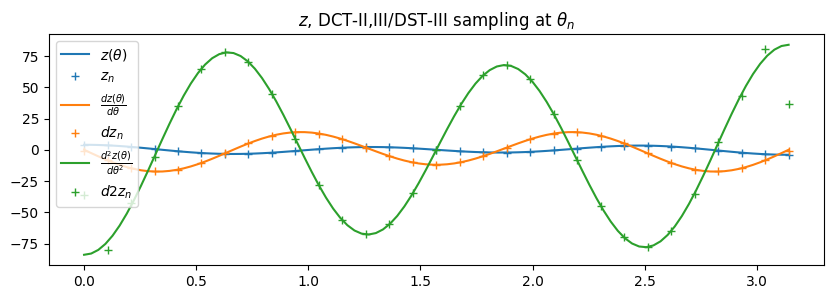

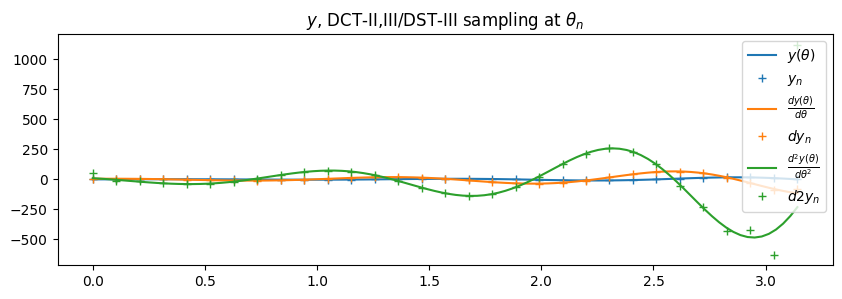

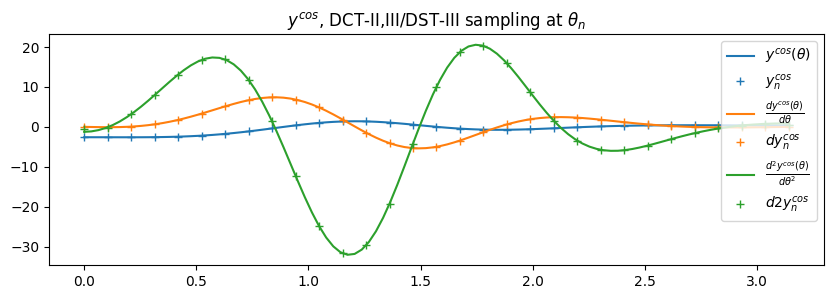

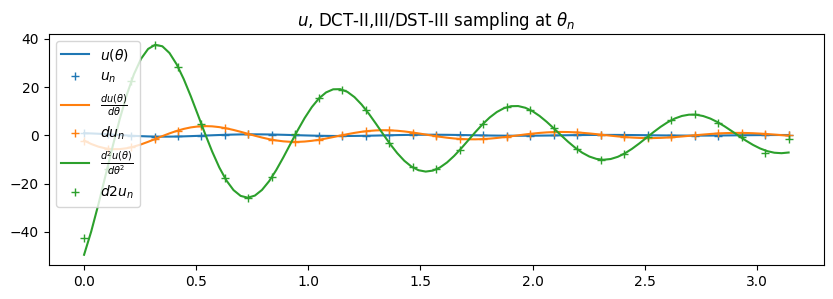

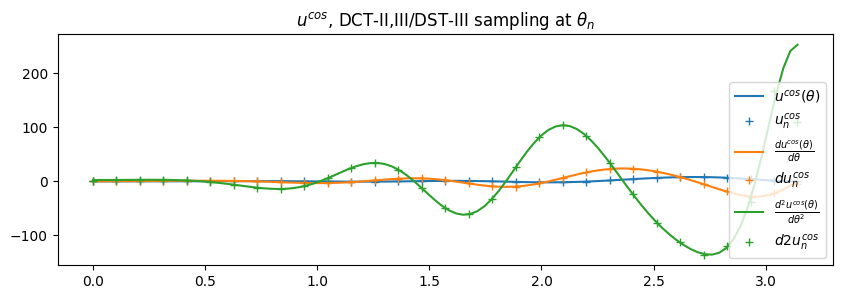

In [12]:
def dctII_Iderivs(f, df, d2f, fname):
	M = 2*(N+1)
	k = np.arange(N+1) # This time *don't* zero out the last index, because the Nyquist term would be at N+1
	
	f_n = f(th_n) # Sample at on-index points
	F_kIII = dct(f_n, 2)
	F_pIII = -k * F_kIII # j * (jk) * Y_k
	F_pIII = np.roll(F_pIII, -1) # shift to left
	df_n = dst(F_pIII, 3) * N/(N+1) /M # DST-III
	F_pIII = -k**2 * F_kIII # (jk)**2 * Y_k
	d2f_n = dct(F_pIII, 3) * (N/(N+1))**2 /M # DCT-III

	Linf.loc[fname, f"II,I"] = '<br/>'.join([f"dy:&emsp;{np.max(np.abs(df_n - df(th_n))):.5g}",
											f"d2y: {np.max(np.abs(d2f_n - d2f(th_n))):.5g}"])

	pyplot.figure(figsize=(10,3))
	pyplot.plot(th, f(th), label=rf"${fname}(\theta)$")
	pyplot.plot(th_n, f_n, 'C0+', label=rf"${fname}_n$")
	pyplot.plot(th, df(th), label=rf"$\frac{{d{fname}(\theta)}}{{d\theta}}$")
	pyplot.plot(th_n, df_n, 'C1+', label=rf"$d{fname}_n$")
	pyplot.plot(th, d2f(th), label=rf"$\frac{{d^2{fname}(\theta)}}{{d\theta^2}}$")
	pyplot.plot(th_n, d2f_n, 'C2+', label=rf"$d2{fname}_n$")
	pyplot.title(rf"${fname}$, DCT-II,III/DST-III sampling at $\theta_n$")
	pyplot.legend()
	pyplot.show()

dctII_Iderivs(z, dz, d2z, 'z')
dctII_Iderivs(y, dy, d2y, 'y')
dctII_Iderivs(y_cos, dy_cos, d2y_cos, r'y^{cos}')
dctII_Iderivs(u, du, d2u, 'u')
dctII_Iderivs(u_cos, du_cos, d2u_cos, r'u^{cos}')

This method does worse on the periodic functions, diverging at the edges. Yet it performs comparably for the aperiodic functions with sharp endpoints. Why?

### Horizontal Squash

Recall that the DCT-II with type-I sampling is [imagining that the function is slightly extended](#analysis-and-discussion) past the last samples. So if we sample all the way to the ends but then treat those points like a type-II sampling, we're *squashing* the interval $[0, \pi]$ in to the interval $[\frac{\pi}{2(N+1)}, \frac{\pi (2N+1)}{2(N+1)}]$ and then trying to find DCT coefficients of *that* function. This is advantageous if we have sharp edges, because we create [wiggle room](#analysis-and-discussion), but for periodic functions which could already be captured in a few coefficients, this makes the function *harder to represent*.

To see this as clearly as possible, let's define a new, even simpler function:

$$
\begin{align*}
y_1(\theta) &= \cos(2\theta)\\
\frac{d}{d\theta}y_1 &= -2\sin(2\theta)
\end{align*}
$$

If we sample this at $\theta_n$ and then use the DCT-II, which assumes the points came from $\theta_{n,II}$, it's as if we sampled a higher frequency, phase-shifted version of the function:

$$
\begin{align*}
y_2(\theta) &= \cos\!\big(\frac{N+1}{N} 2(\theta - \frac{\pi}{M})\big)\\
\frac{d}{d\theta}y_2 &= -\frac{N+1}{N} 2 \sin\!\big(\frac{N+1}{N} 2(\theta - \frac{\pi}{M})\big)
\end{align*}
$$

$y_1(\theta_n) = y_2(\theta_{n,II})$.

In [13]:
N = 6 # Decrease N to see a more exaggerated effect
M = 2*(N+1)
k = np.arange(N+1)
th_n = np.linspace(0, np.pi, N+1, endpoint=True)
th_nII = np.pi/(N+1) * (np.arange(N+1) + 1/2)

y1 = lambda th: np.cos(2*th)
dy1 = lambda th: -2 * np.sin(2*th)
y2 = lambda th: np.cos((N+1)/N * 2 * (th - np.pi/M))
dy2 = lambda th: -(N+1)/N * 2 * np.sin((N+1)/N * 2 * (th - np.pi/M))

y1_n = y1(th_n)
y2_nII = y2(th_nII)
assert np.all(np.abs(y1_n - y2_nII) < 1e-10) # Sampling y1 at th_n is exactly the same as sampling y2 at th_nII

### Periodic Extension

The DCT implicitly extends the function left and right by *copying* the and mirroring interval $[0,\pi]$ over and over and then trying to find coefficients for *that*. Because the DCT-I treats the function as symmetric *around the left and right sample points*, the extension of $y_1$ looks like a pure cosine, which is very easy to fit frequency coefficients to.

Contrast this with $y_2$ on $[0,\pi]$, which curls back downward from the peaks at the outermost $\theta_{n,II}$ samples. Its extension will actually have cusps! And due to the phase shift of $y_2$, we can't get rid of them.

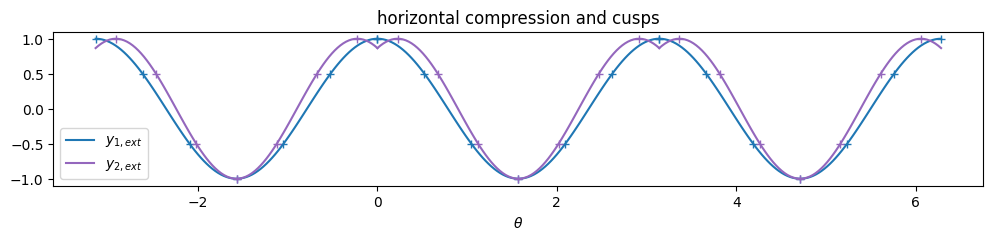

In [14]:
pyplot.figure(figsize=(12,2))
for phi in [0, np.pi, -np.pi]:
	pyplot.plot(th + phi, y1(th), 'C0', label=r"$y_{1,ext}$" if phi==0 else None)
	pyplot.plot(th_n + phi, y1_n, 'C0+')
	pyplot.plot(th + phi, y2(th), 'C4', label=r"$y_{2,ext}$" if phi==0 else None)
	pyplot.plot(th_nII + phi, y2_nII, 'C4+')
pyplot.title("horizontal compression and cusps")
pyplot.xlabel(r'$\theta$')
pyplot.legend();

### Interpolated Reconstructions

We don't actually have to deal with the cusps, because the DCT-II can imagine anything it wants between the endpoints samples. But there is still trouble: The smoothest thing to do is just flatten out at the edges, which causes more widespread changes to the function.

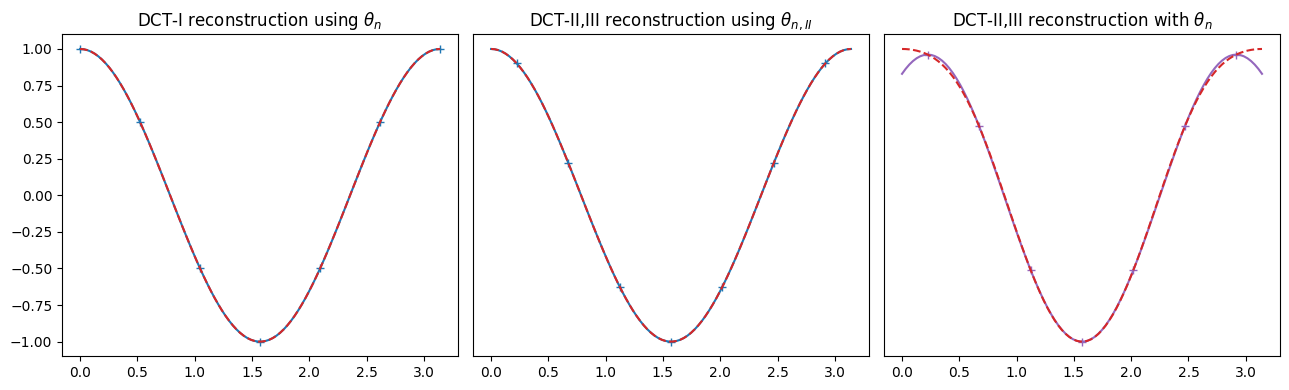

In [15]:
def dct_i_reconstruction(y_n):
    Y_k = dct(y_n, 1)
    y_r = Y_k[0] + Y_k[N]*np.cos(th*N) # (-1)^n = cos(pi*n), pi*n/N = th -> pi*n = th*N
    for k_ in range(1, N):
        y_r += 2*Y_k[k_]*np.cos(th*k_) # continuous th takes the place of th_n = pi*n/N
    y_r /= (2*N)
    return y_r

def dct_ii_reconstruction(y_n):
    Y_k = dct(y_n, 2)
    y_r = Y_k[0]
    dy_r = 0
    for k_ in range(1, N+1):
        y_r += 2*Y_k[k_]*np.cos(k_*th) # th2 = pi * (n + 1/2) / (N+1)
        dy_r -= 2*k_*Y_k[k_]*np.sin(k_*th)
    y_r /= M
    dy_r /= M
    return y_r, dy_r

y1_r = dct_i_reconstruction(y1_n) # Use the DCT-I to reconstruct y1 from th_n sample points 
y1_nII = y1(th_nII)
y1_rII, dy1_rII = dct_ii_reconstruction(y1_nII) # Use the DCT-II to reconstruct y1 from th_n2 sample points
y2_rII, dy2_rII = dct_ii_reconstruction(y2_nII) # Use the DCT-II to try to reconstruct y2 from th_nII sample points

fig, axes = pyplot.subplots(1, 3, figsize=(13,4))
axes[0].plot(th, y1(th))
axes[0].plot(th_n, y1_n, 'C0+')
axes[0].plot(th, y1_r, 'C3--')
axes[0].set_title(r"DCT-I reconstruction using $\theta_n$")
axes[1].plot(th, y1(th), label="y2")
axes[1].plot(th_nII, y1_nII, 'C0+')
axes[1].plot(th, y1_rII, 'C3--')
axes[1].set_yticks([])
axes[1].set_title(r"DCT-II,III reconstruction using $\theta_{n,II}$");
axes[2].plot(th, y2(th), 'C4')
axes[2].plot(th_nII, y2_nII, 'C4+')
axes[2].plot(th, y2_rII, 'C3--')
axes[2].set_yticks([])
axes[2].set_title(r"DCT-II,III reconstruction with $\theta_n$");
pyplot.tight_layout()

If we do as designed, using a corresponding grid sampling and reconstruction (whether I or II), we match the original function perfectly (left two plots), because the extension is easy to represent. But if we sample at on-index points and treat them like off-index points (right figure), the horizontally compressed function isn't fully captured by the reconstruction, not even on the interval $[\frac{\pi}{M}, \frac{2(N+1)}{M}]$ between the outermost sample points. With more samples this phenomenon improves because the frequency factor $\frac{N}{N+1} \rightarrow 1$ and phase shift $\frac{\pi}{2(N+1)} \rightarrow 0$ as $N \rightarrow \infty$, but the error never fully goes away.

### Derivatives of the Interpolant

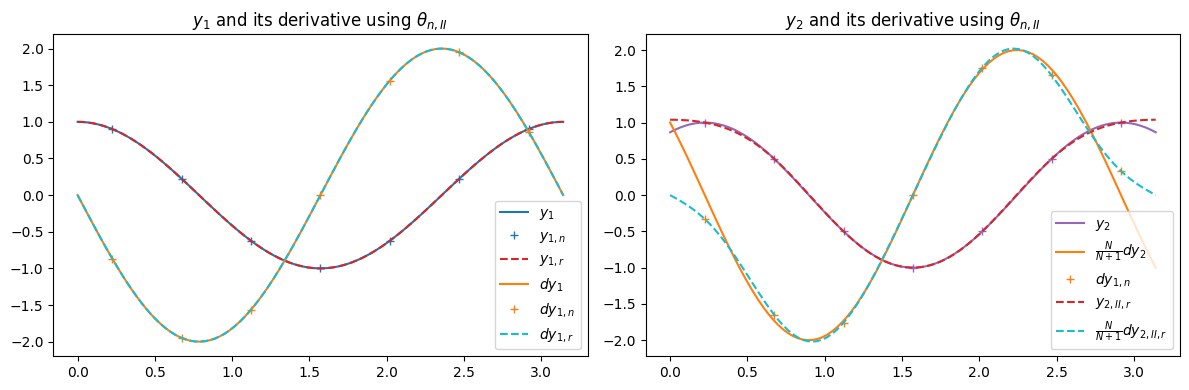

In [16]:
Y_kII = dct(y1_nII, 2)
Y_pII = -k * Y_kII # j * (jk) * Y_k
Y_pII = np.roll(Y_pII, -1) # shift to left
dy1_nII = dst(Y_pII, 3)/M

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(th, y1(th), label=r"$y_1$")
axes[0].plot(th_nII, y1_nII, 'C0+', label=r"$y_{1,n}$")
axes[0].plot(th, y1_r, 'C3--', label=r"$y_{1,r}$")
axes[0].plot(th, dy1(th), label=r"$dy_1$")
axes[0].plot(th_nII, dy1_nII, 'C1+', label=r"$dy_{1,n}$")
axes[0].plot(th, dy1_rII, 'C9--', label=r"$dy_{1,r}$")
axes[0].set_title(r"$y_1$ and its derivative using $\theta_{n,II}$")
axes[0].legend()

Y_kIII = dct(y1_n, 2) # = dct(y2_nII, 2), DCT-II of y1 with th_n1 sampling
Y_pIII = -k * Y_kIII # j * (jk) * Y_k
Y_pIII = np.roll(Y_pIII, -1) # shift to left
dy1_n = dst(Y_pIII, 3) * N/(N+1) /M

axes[1].plot(th, y2(th), 'C4', label=r"$y_2$")
axes[1].plot(th_nII, y2_nII, 'C4+')
axes[1].plot(th, dy2(th)*N/(N+1), 'C1', label=r"$\frac{N}{N+1} dy_2$")
axes[1].plot(th_nII, dy1_n, 'C1+', label=r"$dy_{1,n}$")
axes[1].plot(th, y2_rII, 'C3--', label=r"$y_{2,II,r}$")
axes[1].plot(th, dy2_rII*N/(N+1), 'C9--', label=r"$\frac{N}{N+1} dy_{2,II,r}$")
axes[1].set_title(r"$y_2$ and its derivative using $\theta_{n,II}$")
axes[1].legend()
pyplot.tight_layout()

Here little $r$ stands for "reconstruction" from corresponding sample points.

If we calculate spectral derivative samples and plot against the actual interpolant's derivative, then we can see they align. This is where the systematic error is coming from! Basically, the mismatch between $y_2$ and its reconstruction, even though it's is essentially zero *at* the sample points, is significant enough *between* sample points to corrupt the slopes at those points.

## Conclusion

In [17]:
display(HTML(Linf.style.set_caption("L∞").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,I,II,"II,I"
z,dy: 6.9278e-14d2y: 1.5223e-12,dy: 3.908e-14d2y: 9.0239e-13,dy: 1.372d2y: 47.452
y,dy: 45.17d2y: 2923.2,dy: 36.292d2y: 1301.8,dy: 39.085d2y: 1354
y^{cos},dy: 1.3989e-14d2y: 3.8014e-13,dy: 1.4211e-14d2y: 3.2863e-13,dy: 0.022091d2y: 0.71381
u,dy: 0.89999d2y: 51.078,dy: 0.75486d2y: 25.808,dy: 0.17685d2y: 7.0183
u^{cos},dy: 0.0031527d2y: 0.071454,dy: 0.0043804d2y: 0.013264,dy: 4.3288d2y: 143.85


Since taking the Chebyshev derivative involves cosine-spaced sampling, which effectively warps any function, even ones with steep slopes at the domain edges, we'll be dealing with the periodic case, which means we won't actually get the [energy compaction benefit](https://dsp.stackexchange.com/questions/96172/why-does-the-dct-ii-have-better-energy-compaction-than-dct-i) of the DCT-II.

For the periodic case, although it's plausible to sample with $\theta_n$ and then use a DCT-II/III construction, this is fundamentally not as accurate as using $\theta_n$ with the DCT-I or $\theta_{n,II}$ with the DCT-II. Of those two latter methods, neither is fundamentally more accurate than the other, but only the type-I sampling conveniently includes the domain endpoints, which is important for boundary value problems. Since supporting both options is inconvenient and confusing, **henceforth only the DCT-I will be considered**. 